# Documentación

Se llaman las librerías que serán utilizadas. Entre ellas dos librerías propias las cuales son:

- url_config: Esta libreria contiene una función a través de la cual se realiza el webscrapping de varios periodicos en línea.
- utilitools: Libreria de varios usos, se usa para configurar el arbol de rutas particularmente. 

In [1]:
import requests
import re
import nltk
import random
import pandas as pd
import numpy as np

from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from bs4 import BeautifulSoup
from urllib import request
from url_config import *
from utilitools import *
from matplotlib import pyplot as plt

Creamos las siguientes funciones para el proceso de entrenamiento y el proceso de tokenización de las noticias.

In [2]:
# Esta función regresa los tokens del cuerpo de la noticia
def tokenizar_url(url):
    #Se envia solicitud a la página
    resultado=requests.get(url)

    #Se solicita el texo
    content=resultado.text
    soup=BeautifulSoup(content, 'lxml')
    #print(url)

    if 'espectador' in url.lower(): box = bs_espectador(soup)
    elif 'semana' in url.lower(): box = bs_semana(soup)
    elif 'larepublica' in url.lower(): box = bs_larepublica(soup)
    elif 'portafolio' in url.lower(): box = bs_portafolio(soup)
    elif 'elpais' in url.lower(): box = bs_elpais(soup)
    elif 'eltiempo' in url.lower(): box = bs_eltiempo(soup)
    elif 'infobae' in url.lower(): box = bs_infobae(soup)
    elif 'laopinion' in url.lower(): box = bs_laopinion(soup)
    elif 'redmas' in url.lower(): box = bs_redmas(soup)
    elif 'bloomberglinea' in url.lower(): box = bs_bloomberglinea(soup)
    elif 'elespanol' in url.lower(): box = bs_elespanol(soup)
    elif 'elcolombiano' in url.lower(): box = bs_elcolombiano(soup)
    elif 'cnn' in url.lower(): box = bs_cnn(soup)
    elif 'bbc' in url.lower(): box = bs_bbc(soup)

    else: return 'no config'

    tokenizer=RegexpTokenizer('\w+')
    tokens=tokenizer.tokenize(box)
    tokens=[token.lower() for token in tokens]

    return tokens

# Esta función regresa un top de las palabras mas utilizadas dentro de las noticias, por defecto defecto devuelve el top 100
def top_freqdst(tokens,n=100):
    stops = stopwords.words('spanish')

    filtered_tokens = [token for token in tokens if token not in stops]

    f_dst = FreqDist(filtered_tokens)
    top_n = f_dst.most_common(n)

    return (top_n)

# Calcula la riqueza léxica del cuerpo de la noticia. Este calculo se realiza con el total de palabras diferentes dividido el total de palabras
def riq_lex(tokens):
    vocabulario = sorted(set(tokens))
    return len(vocabulario)/len(tokens)

# Retorna el top de n-gramas, es decir, las n agrupaciones de palabras que componen el contenido del texto. Por defecto devuelve el top 100 de bi-gramas
def top_ngrams_freqdist(tokens,n=2,m=100):
    n_grams = ngrams(tokens, n)
    
    token_grams = [ ' '.join(elms) for elms in n_grams]
    
    f_dst = FreqDist(token_grams)
    top_m = f_dst.most_common(m) 
    return (top_m)

def vocab(tokens):
    vocabulario = sorted(set(tokens))
    return vocabulario

    

# Esta función se utiliza para agrupar los parametros de entrenamiento del modelo de clasificación Bayesiano
def atributos(tokens):
    atrib = {}
    
    top_freqdist = top_freqdst(tokens,n=10)
    for x in top_freqdist:
        atrib['top_freqdist({})'.format(x[0])] = x[1]
    
    bi_gram_freqdist = top_ngrams_freqdist(tokens,n=2,m=10)
    for x in bi_gram_freqdist:
        atrib['top_2gram({})'.format(x[0])] = x[1]
    
    tri_gram_freqdist = top_ngrams_freqdist(tokens,n=3,m=10)
    for x in tri_gram_freqdist:
        atrib['top_3gram({})'.format(x[0])] = x[1]
    
    four_gram_freqdist = top_ngrams_freqdist(tokens,n=4,m=10)
    for x in four_gram_freqdist:
        atrib['top_4gram({})'.format(x[0])] = x[1]
    
    vocabulario = vocab(tokens)
    for x in vocabulario:
        atrib['vocab({})'.format(x)] = 1

    toklen = len(tokens)
    atrib['vocab(token_len)'] = toklen

    #atrib['riq_lex'] = riq_lex(tokens)

    return atrib


Se realiza la lectura del arbol de archivos del proyecto. 

In [3]:
data = leer_paths('data')
recomendador = leer_paths('recomendador')
scripts = leer_paths('scripts')

Se procede a cargar como dataframe un excel que contiene las URL clasificadas previamente, las cuales serán utilizadas como entrenamiento. Adicionalmente, se realiza el proceso de tokenización del cuerpo de las noticias

In [5]:
df = pd.read_excel(os.path.join(data,'archivos_auxiliares\\url_noticias_clasificadas.xlsx'),sheet_name='Hoja 4')
df = df[['url','categoria']]
df['tokens'] = df['url'].apply(tokenizar_url)

Se realiza el entrenamiento del modelo de clasificación Bayesiana. Inicialmente se cuenta con un total de 18 noticias, las cuales corresponden a 3 noticias por cada categoría. Para el proceso de entrenamiento, se tendrán en cuenta 10 de ellas y las 8 restantes se usan el testeo. Por otra parte, se realiza la medida del accuracy

In [6]:
n = 50

def test_ia():
    fset = [(atributos(texto), clase) for texto, clase in zip(df['tokens'].values, df['categoria'].values)]
    random.shuffle(fset)
    setlen = len(fset)
    train, test = fset[:2*setlen//3], fset[setlen//3:]
    classifier = nltk.NaiveBayesClassifier.train(train)
    
    return nltk.classify.accuracy(classifier, test)

ssk = np.zeros(n)
for i in range(n):
    ssk[i] = test_ia()

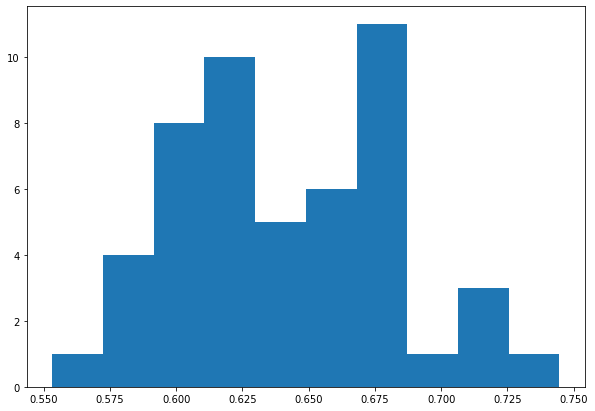

In [7]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(ssk, bins = 10)
 
# Show plot
plt.show()

In [8]:
fset = [(atributos(texto), clase) for texto, clase in zip(df['tokens'].values, df['categoria'].values)]
random.shuffle(fset)
setlen = len(fset)
train, test = fset[:2*setlen//3], fset[setlen//3:]
classifier = nltk.NaiveBayesClassifier.train(train)
print(nltk.classify.accuracy(classifier, test)) #se mide el accuracy

0.6595744680851063


El accuracy mas alto obtenido con las condiciones dadas, es de 0.625, sin embargo, debemos tener en cuenta que actualmente el valor fluctua debido a que la muestra de entrenamiento es muy pequeña y esto genera discrepancias en cada re entrenamiento. Esto se puede solucionar, teniendo una base de noticias clasificadas mas grande

Una vez entrenado el modelo, procedemos a cargar el archivo que contiene las noticias

In [9]:
# Esta función carga el archivo .csv que se encuentra en la ruta path con el nombre csv_file como un dataframe, 
def leer_csv(path,csv_file):
    '''
    Inserta ruta de carpeta donde se encuentra el archivo y nombre de archivo para hacer lectura de archivo como DataFrame
    '''
    for file in os.listdir(path):
        file_path = os.path.join(path,file)

        if csv_file in file_path:
            df = pd.read_csv(file_path)
    return df

df_noticias = leer_csv(data,'noticias.csv')


Se agrega la columna que contiene los tokens del cuerpo de la noticia

In [10]:
df_noticias['tokens'] = df_noticias['news_text_content'].apply(word_tokenize)

Se agrega una columna donde se clasifica la noticia, utilizando el clasificador entrenado

In [11]:
df_noticias['clase'] = df_noticias['tokens'].apply(lambda x: classifier.classify(atributos(x)))

Se exportan los datos

In [12]:
df_noticias.drop(['tokens','news_title','news_text_content'], axis=1,inplace=True)
df_noticias.to_csv(os.path.join(data,'output\\categorizacion.csv'),index=False)

In [13]:
df_noticias

,news_id,news_url_absolute,news_init_date,news_final_date,clase
0,news10006,https://www.bluradio.com/economia/precio-dolar...,2022-07-30,2022-08-14,Macroeconomía
1,news10011,https://www.semana.com/economia/macroeconomia/...,2022-07-30,2022-08-14,Macroeconomía
2,news10015,https://elcomercio.pe/respuestas/que/gustavo-p...,2022-07-30,2022-08-14,Macroeconomía
3,news10028,https://www.lanacion.com.ar/estados-unidos/cua...,2022-07-30,2022-08-14,Macroeconomía
4,news10029,https://www.lanacion.com.ar/estados-unidos/com...,2022-07-30,2022-08-14,Macroeconomía
...,...,...,...,...,...
23372,news99983,https://www.tuuputchika.com/2022/08/07/como-av...,2022-07-30,2022-08-14,Macroeconomía
23373,news99989,https://www.publimetro.com.mx/nacional/2022/08...,2022-07-30,2022-08-14,Macroeconomía
23374,news99991,https://www.laopinion.com.co/columnistas/la-de...,2022-07-15,2022-07-30,Macroeconomía
23375,news99996,https://www.laopinion.com.co/premium/economia/...,2022-07-15,2022-07-30,Macroeconomía
